## Cargado DETRAC
```markdown
En esta primera etapa se carga un subconjunto del dataset **DETRAC** en su versión original, es decir, sin ningún tipo de modificación artificial. El objetivo es tener una referencia clara de cómo luce el material sobre el cual se construye todo el pipeline. 

DETRAC es un dataset relativamente **limpio**, con buena iluminación y condiciones estables, por lo que funciona como base sólida para entrenar un modelo generalista de detección. A partir de la visualización pueden observarse los valores típicos de exposición, contraste y colores reales del entorno, lo cual nos permite calibrar qué tan lejos se encuentra este dominio del dominio “sucio” que queremos estudiar más adelante.

La grilla mostrada funciona como una inspección rápida para validar que:
  
- Las rutas fueron cargadas correctamente.  
- La estructura del dataset es consistente (`images/train/…`).  
- Las secuencias mantienen continuidad temporal.  
- No hay imágenes corruptas ni problemas de lectura.  

Este paso inicial es clave porque define el **punto de partida visual** sobre el cual después comparamos los efectos del ensuciamiento sintético, el preprocesamiento clásico y eventualmente el fine-tuning del modelo.```

Total imágenes en train: 82085 | Usando: 1641 (2.0%)
Imágenes totales en subset: 1641
Ejemplo de path: C:\Users\bianc\Vision\tpf\DETRAC_Upload\images\train\MVI_39851_img00830.jpg


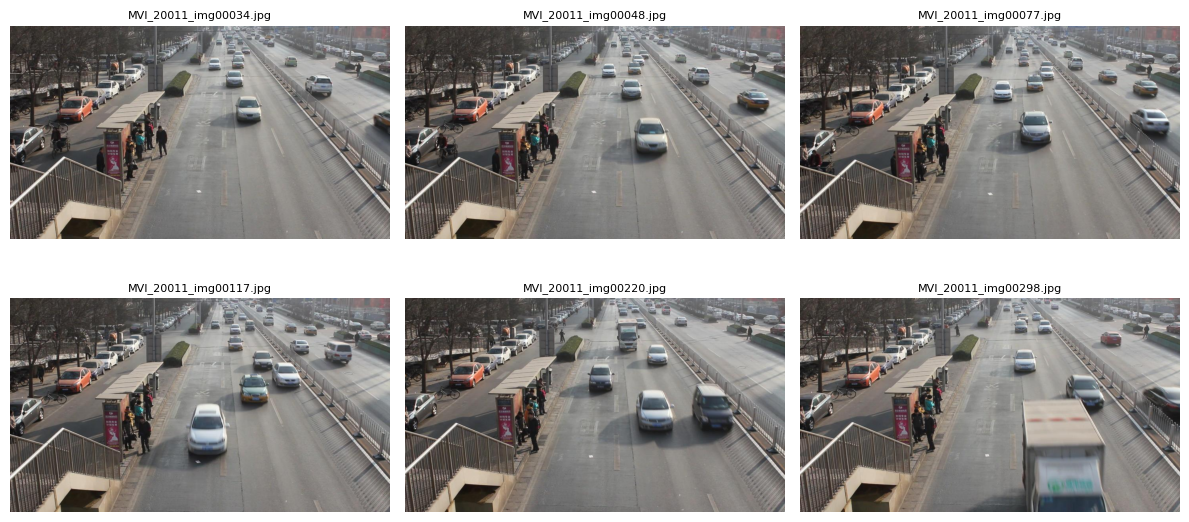

In [6]:
from pathlib import Path
from src.loading import load_dataset_subset
from src.visualization import preview_sequence_grid

# 1) Cargar subset de DETRAC (train)
subset = load_dataset_subset(
    base_dir=r"C:\Users\bianc\Vision\tpf\DETRAC_Upload",
    split="train",
    percent=2.0,   # podés subirlo si querés usar más datos
    shuffle=True
)

clean_image_paths = subset["image_paths"]
clean_label_paths = subset["label_paths"]

print("Imágenes totales en subset:", len(clean_image_paths))
print("Ejemplo de path:", clean_image_paths[0])

# 2) Visualizar imágenes limpias
preview_sequence_grid(
    image_paths=clean_image_paths,
    sequence_filter="MVI_20011",  # o None si querés mezclar todo
    n_rows=2,
    n_cols=3,
    random_sample=False,
)


## Ensuciamiento sintético de DETRAC + visualización

```markdown
En esta sección se genera un conjunto de imágenes **sucias sintéticas** a partir del dataset DETRAC limpio. La idea es simular condiciones adversas como polvo, arena, velado de la lente o niebla ligera, todas situaciones frecuentes cuando la cámara está expuesta al ambiente urbano. 

El ensuciamiento sirve para crear un dominio de entrenamiento más desafiante, acercándose visualmente al dataset **`archive`**, que contiene suciedad real pero en mucha menor cantidad. Para ello, se toma un 50% del subset cargado y se transforman las imágenes mediante la función `apply_dirty_effect`, controlando la intensidad con el parámetro `strength`.

La visualización posterior permite evaluar la **coherencia del ensuciamiento**:
  
- Cómo se degradan el contraste y la nitidez.  
- Si aparece una dominante de color cálida (típica de polvo).  
- Si el nivel de degradación sigue siendo reconocible para el modelo.  

Este chequeo visual es imprescindible porque garantiza que las transformaciones sintéticas no rompan la escena ni introduzcan artefactos inesperados que podrían sesgar el entrenamiento.```


Total imágenes: 1641
Para ensuciar: 820
Quedan limpias: 821
Imágenes sucias generadas: 820


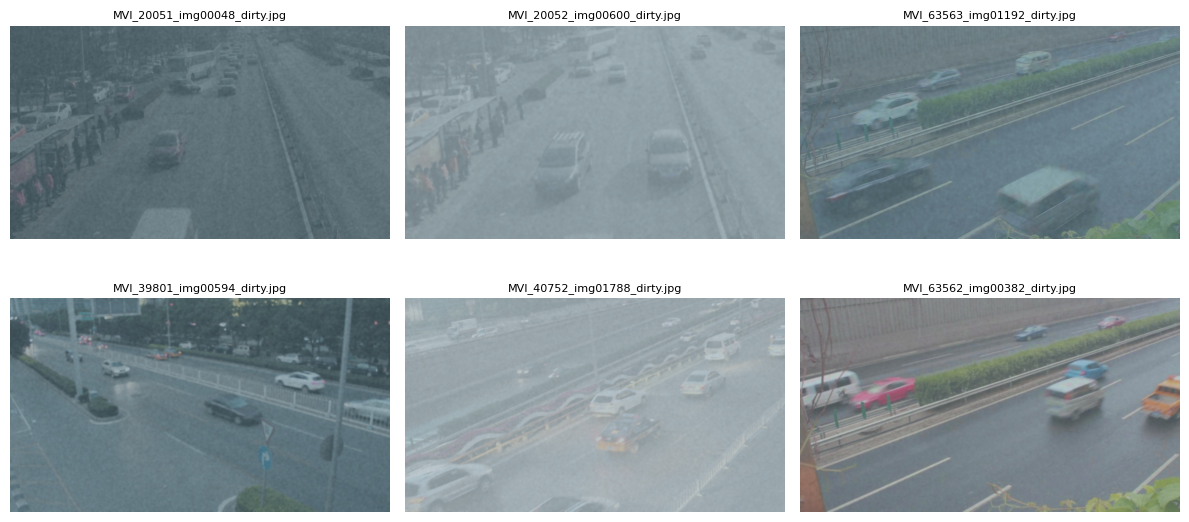

In [7]:
from src.augmentation import apply_dirty_effect
from src.preprocessing import generate_preprocessed_dataset
from src.visualization import preview_sequence_grid
from pathlib import Path

# 1) Definir 50% sucio / 50% limpio a partir del subset ya cargado
n_total = len(clean_image_paths)
n_dirty = n_total // 2

images_for_dirty = clean_image_paths[:n_dirty]
labels_for_dirty = clean_label_paths[:n_dirty]

images_clean_keep = clean_image_paths[n_dirty:]
labels_clean_keep = clean_label_paths[n_dirty:]

print("Total imágenes:", n_total)
print("Para ensuciar:", len(images_for_dirty))
print("Quedan limpias:", len(images_clean_keep))

# 2) Función wrapper para aplicar suciedad
def dirty_fn(img_bgr):
    return apply_dirty_effect(img_bgr, strength=0.9)

synthetic_dirty_dir = r"C:\Users\bianc\Vision\tpf\DETRAC_synth_dirty"

dirty_image_paths, dirty_label_paths = generate_preprocessed_dataset(
    image_paths=images_for_dirty,
    label_paths=labels_for_dirty,
    output_base_dir=synthetic_dirty_dir,
    preproc_fn=dirty_fn,
    suffix="dirty"
)

print("Imágenes sucias generadas:", len(dirty_image_paths))

# 3) Visualizar algunas imágenes sucias
preview_sequence_grid(
    image_paths=dirty_image_paths,
    sequence_filter=None,
    n_rows=2,
    n_cols=3,
    random_sample=True,
)


## Creación del dataset MIXED (50% limpio / 50% sucio) y guardado físico

```markdown
Aquí se construye un dataset **mixto** combinando la mitad de las imágenes originales del DETRAC y la mitad de sus versiones sucias sintéticas. A diferencia de la visualización previa, donde los datos viven solo en memoria, esta celda crea un **dataset físico persistente** en disco (`DETRAC_mixed_50_50`), completamente separado de las carpetas originales.

Esta decisión es fundamental por dos motivos:

1. Permite reproducir experimentos sin recalcular el ensuciamiento cada vez.  
2. Aísla el conjunto mixto como un dataset formal, útil para entrenamientos futuros, métricas y trazabilidad del proyecto.

En esta etapa se verifica que:
- Todas las imágenes fueron copiadas correctamente.  
- Sus labels correspondientes se copiaron en paralelo sin alterar el contenido.  
- La estructura final cumple el formato estándar de YOLO (`images/` y `labels/`).

El resultado es un dataset consistente que refleja un equilibrio controlado entre el dominio limpio y el dominio sucio sintético, ideal para analizar cómo responde el modelo ante variaciones en la calidad visual.```

In [8]:
from pathlib import Path
import shutil

# Directorios del dataset mixed físico
mixed_dir = Path(r"C:\Users\bianc\Vision\tpf\DETRAC_mixed_50_50")
mixed_images = mixed_dir / "images"
mixed_labels = mixed_dir / "labels"

mixed_images.mkdir(parents=True, exist_ok=True)
mixed_labels.mkdir(parents=True, exist_ok=True)

# 1) Copiar imágenes LIMPIAS + labels
for img_path, lbl_path in zip(images_clean_keep, labels_clean_keep):
    shutil.copy(str(img_path), str(mixed_images / img_path.name))
    shutil.copy(str(lbl_path), str(mixed_labels / lbl_path.name))

# 2) Copiar imágenes SUCIAS + labels
for img_path, lbl_path in zip(dirty_image_paths, dirty_label_paths):
    shutil.copy(str(img_path), str(mixed_images / img_path.name))
    shutil.copy(str(lbl_path), str(mixed_labels / lbl_path.name))

# 3) Chequeo rápido
mixed_image_paths = sorted(list(mixed_images.glob("*.jpg")))
mixed_label_paths = sorted(list(mixed_labels.glob("*.txt")))

print("DETRAC_mixed_50_50 creado.")
print("Imágenes en mixed:", len(mixed_image_paths))
print("Labels en mixed:", len(mixed_label_paths))


DETRAC_mixed_50_50 creado.
Imágenes en mixed: 3262
Labels en mixed: 3262


## Carga del dataset MIXED desde disco y creación del YAML

```markdown
Con el dataset mixto ya consolidado en disco, esta celda lo vuelve a cargar utilizando exactamente el mismo mecanismo que cualquier otro dataset YOLO. Esto confirma que la estructura creada es válida y que puede emplearse sin depender de los pasos de ensuciamiento previos.

Una vez cargadas las rutas, se genera el archivo `.yaml` correspondiente, que contiene:
- Las rutas a los archivos `train.txt` y `val.txt`, construidos automáticamente.  
- El diccionario de clases de UA-DETRAC.  
- La referencia al nuevo dataset como fuente de entrenamiento.

Este YAML se convierte en el punto de entrada para cualquier entrenamiento futuro con YOLO, permitiendo probar el rendimiento del modelo bajo un dataset que mezcla escenas limpias con escenas degradadas artificialmente. Esta separación por etapas —crear, guardar, cargar, entrenar— mejora la claridad y la reproducibilidad del pipeline experimental.```



In [9]:
from pathlib import Path
from typing import Dict
from src.loading import load_dataset_subset
from src.training import create_yolo_subset_config

# 1) Cargar dataset MIXED físico (sin tener que rehacer nada previo)
subset_mixed = load_dataset_subset(
    base_dir=r"C:\Users\bianc\Vision\tpf\DETRAC_mixed_50_50",
    split=None,
    images_subdir="images",
    labels_subdir="labels",
    percent=100.0,
    shuffle=True,
)

mixed_image_paths = subset_mixed["image_paths"]
mixed_label_paths = subset_mixed["label_paths"]

print("Mixed cargado desde disco:")
print("Imágenes:", len(mixed_image_paths))
print("Ejemplo:", mixed_image_paths[0])

# 2) Diccionario de clases de UA-DETRAC
UA_DETRAC_CLASS_NAMES: Dict[int, str] = {
    0: "others",
    1: "car",
    2: "van",
    3: "bus",
}

# 3) Crear YAML + train/val.txt para el MIXED
yaml_path_mixed = Path(r"C:\Users\bianc\Vision\tpf\configs\detrac_mixed_50_50.yaml")

yaml_path, train_txt, val_txt = create_yolo_subset_config(
    image_paths=mixed_image_paths,
    yaml_path=yaml_path_mixed,
    class_names=UA_DETRAC_CLASS_NAMES,
    train_ratio=0.8,
)

print("YAML creado:")
print("yaml:", yaml_path)
print("train.txt:", train_txt)
print("val.txt:", val_txt)

Total imágenes en all: 3262 | Usando: 3262 (100.0%)
Mixed cargado desde disco:
Imágenes: 3262
Ejemplo: C:\Users\bianc\Vision\tpf\DETRAC_mixed_50_50\images\MVI_40181_img01327_dirty.jpg
Config YOLO creada:
  YAML:   C:\Users\bianc\Vision\tpf\configs\detrac_mixed_50_50.yaml
  train:  C:\Users\bianc\Vision\tpf\configs\detrac_mixed_50_50_train.txt (2609 imágenes)
  val:    C:\Users\bianc\Vision\tpf\configs\detrac_mixed_50_50_val.txt (653 imágenes)
YAML creado:
yaml: C:\Users\bianc\Vision\tpf\configs\detrac_mixed_50_50.yaml
train.txt: C:\Users\bianc\Vision\tpf\configs\detrac_mixed_50_50_train.txt
val.txt: C:\Users\bianc\Vision\tpf\configs\detrac_mixed_50_50_val.txt


## Cargar dataset ARCHIVE (sucio real) y visualizarlo

```markdown
Finalmente se carga el dataset **archive**, que representa el dominio sucio real: imágenes capturadas en condiciones de polvo, arena o suciedad genuina sobre la lente. A diferencia de DETRAC, este conjunto es mucho más pequeño, pero su valor radica en que refleja fielmente las condiciones donde el modelo debe operar en la práctica.

La visualización permite comparar inmediatamente este dominio con el ensuciamiento sintético generado anteriormente. Es útil observar:

- La textura real de la suciedad.  
- Cuán intensa es la degradación comparada con la versión sintética.  
- Si los objetos siguen siendo distinguibles o si el ruido domina la escena.  

Este dataset jugará un rol clave más adelante, ya sea para evaluación o para un fine-tuning final, ya que aporta muestras auténticas del entorno problemático que queremos resolver. Su revisión visual inicial es esencial para entender el grado real de deterioro del dominio objetivo.```

Total imágenes en all: 1027 | Usando: 1027 (100.0%)
Imágenes en ARCHIVE: 1027
Ejemplo: C:\Users\bianc\Vision\tpf\archive\images\sand_storm-910.jpg


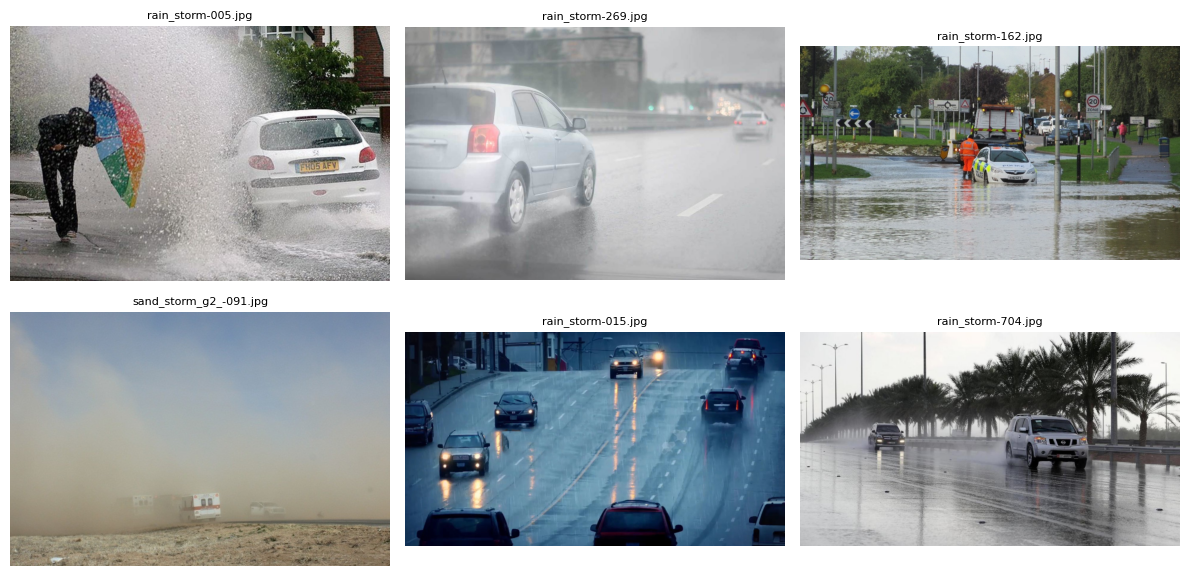

In [10]:
archive_subset = load_dataset_subset(
    base_dir=r"C:\Users\bianc\Vision\tpf\archive",
    split=None,                    # porque NO tiene train/val
    images_subdir="images",
    labels_subdir="labels",
    percent=100.0,                 # cargar todo
    shuffle=True
)

archive_image_paths = archive_subset["image_paths"]
archive_label_paths = archive_subset["label_paths"]

print("Imágenes en ARCHIVE:", len(archive_image_paths))
print("Ejemplo:", archive_image_paths[0])

# Visualizamos algunas imágenes sucias reales del dataset archive
preview_sequence_grid(
    image_paths=archive_image_paths,
    sequence_filter=None,
    n_rows=2,
    n_cols=3,
    random_sample=True
)
